# Medical Appointment Analysis

In this notebook we will try to analyze why would some patient not show up for his medical appointment and whether there are reasons for that using the data we have.
We will try to find some correlation between the different attributes we have and whether the patient shows up or not. The dataset we are going to use contains 110.527 medical appointments and its 14 associated variables ( PatientId, AppointmentID, Gender, ScheduledDay, AppointmentDay, Age, Neighbourhood, Scholarship, Hypertension, Diabetes, Alcoholism, Handcap', SMS_received, No-show )

### Questions to answer

*   What is the percentage of no-show?
*   What factors are important for us to know in order to predict if a patient will show up for their scheduled appointment?
    *   Is the time gender related to whether a patient will show or not?
    *   Are patients with scholarship more likely to miss their appointment?
    *   Are patients who don't recieve sms more likely to miss their appointment?
    *   Is the time difference between the scheduling and appointment related to whether a patient will show?
    *   Does age affect whether a patient will show up or not?


### Data Dictionary
- **PatientId**
    Identification of a patient
- **AppointmentID**
    Identification of each appointment
- **Gender**
Male or Female . Female is the greater proportion, woman takes way more care of they health in comparison to man.
- **AppointmentDate**
The day of the actuall appointment, when they have to visit the doctor.
- **ScheduledDate**
The day someone called or registered the appointment, this is before appointment of course.
- **Age**
How old is the patient.
- **Neighbourhood**
Where the appointment takes place.
- **Scholarship**
True of False
- **Hipertension**
True or False
- **Diabetes**
True or False
- **Alcoholism**
True or False
- **Handcap**
True or False
- **SMS_received**
1 or more messages sent to the patient.
- **No-show**
True or False.

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px
#choose plots style
sns.set_style('darkgrid')
#make sure plots are inline with the notebook
%matplotlib inline
from plotly.subplots import make_subplots
import plotly.graph_objects as go

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import warnings
warnings.filterwarnings('ignore')

# Defined functions

In [3]:
def add_assistance_percentage_per_indicator(df, indicator):
    # Define column name
    col_name = "Total "+indicator+" appointments"

    # Add a column for the total appointmens per indicator class to get the percentage
    df[col_name] = df[indicator].map(dict(df.groupby([indicator])["Assistance"].sum()))

    # Add a column representing the percentage of assistance to the apointment
    df["Percentage of appointments"] = (df["Assistance"] * 100 ) / df[col_name].astype(float)

    return df

In [4]:
def plot_missing_assistance_percentage_per_indicator(df, indicator, title):

    # Plot appointments missing rate by scholarship class
    days = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

    fig = px.bar(df[df["Assisted"] == False ],
                title =title,
                color=indicator, y="Percentage of appointments", x=indicator,
                labels = {
                    "Percentage of appointments" : "Percentage of missed appointments (%)"
                },
                category_orders={
                    indicator: days
                },
                text_auto=".4s")

    # Set values over the bars
    fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)

    # Hide legend
    fig.update_layout(showlegend=False)

    fig.show()

In [5]:
import seaborn as sns

def plot_confusion_matrix(cm, title="Confusion Matrix"):
    plt.figure(figsize=(6,6))
    sns.set(font_scale=1.5)
    ax = sns.heatmap(cm, annot=True, annot_kws={"size":16}, fmt='g', cmap='Blues', cbar=False)

    ax.set_xlabel("Predicted values")
    ax.xaxis.set_ticklabels(['Negative','Positive'])

    ax.set_ylabel("Actual values")
    ax.yaxis.set_ticklabels(['Negative','Positive'])

    ax.set_title(title)

In [6]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(x_test, y_test, model):

    y_score = model.predict_proba(x_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, y_score)

    fig = px.area(
        x=fpr, y=tpr,
        title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
        labels=dict(x='False Positive Rate', y='True Positive Rate'),
        width=700, height=500
    )

    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1
    )

    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.update_xaxes(constrain='domain')
    fig.show()

# Dataset Overview

### Loading the dataset and checking the columns we have


In [7]:
df = pd.read_csv('/kaggle/input/noshowappointments/KaggleV2-May-2016.csv')
df.head()

PatientId  AppointmentID Gender          ScheduledDay  \
0  2.987250e+13        5642903      F  2016-04-29T18:38:08Z   
1  5.589978e+14        5642503      M  2016-04-29T16:08:27Z   
2  4.262962e+12        5642549      F  2016-04-29T16:19:04Z   
3  8.679512e+11        5642828      F  2016-04-29T17:29:31Z   
4  8.841186e+12        5642494      F  2016-04-29T16:07:23Z   

         AppointmentDay  Age      Neighbourhood  Scholarship  Hipertension  \
0  2016-04-29T00:00:00Z   62    JARDIM DA PENHA            0             1   
1  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             0   
2  2016-04-29T00:00:00Z   62      MATA DA PRAIA            0             0   
3  2016-04-29T00:00:00Z    8  PONTAL DE CAMBURI            0             0   
4  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             1   

   Diabetes  Alcoholism  Handcap  SMS_received No-show  
0         0           0        0             0      No  
1         0           0        0             0      No  
2         0           0        0             0      No  
3         0           0        0             0      No  
4         1           0        0             0      No

In [8]:
# Get the shape and types of our data
print(df.shape)
pd.DataFrame(df.dtypes)

(110527, 14)


0
PatientId       float64
AppointmentID     int64
Gender           object
ScheduledDay     object
AppointmentDay   object
Age               int64
Neighbourhood    object
Scholarship       int64
Hipertension      int64
Diabetes          int64
Alcoholism        int64
Handcap           int64
SMS_received      int64
No-show          object

In [9]:
# Get some statistics about our data
df.describe()

PatientId  AppointmentID            Age    Scholarship  \
count  1.105270e+05   1.105270e+05  110527.000000  110527.000000   
mean   1.474963e+14   5.675305e+06      37.088874       0.098266   
std    2.560949e+14   7.129575e+04      23.110205       0.297675   
min    3.921784e+04   5.030230e+06      -1.000000       0.000000   
25%    4.172614e+12   5.640286e+06      18.000000       0.000000   
50%    3.173184e+13   5.680573e+06      37.000000       0.000000   
75%    9.439172e+13   5.725524e+06      55.000000       0.000000   
max    9.999816e+14   5.790484e+06     115.000000       1.000000   

        Hipertension       Diabetes     Alcoholism        Handcap  \
count  110527.000000  110527.000000  110527.000000  110527.000000   
mean        0.197246       0.071865       0.030400       0.022248   
std         0.397921       0.258265       0.171686       0.161543   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       4.000000   

        SMS_received  
count  110527.000000  
mean        0.321026  
std         0.466873  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         1.000000  
max         1.000000

In [10]:
# Show data basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [11]:
# Check for missing values in our data
df.isna().any()

PatientId         False
AppointmentID     False
Gender            False
ScheduledDay      False
AppointmentDay    False
Age               False
Neighbourhood     False
Scholarship       False
Hipertension      False
Diabetes          False
Alcoholism        False
Handcap           False
SMS_received      False
No-show           False
dtype: bool

In [12]:
# Check for duplicated rows in our data
df.duplicated().any()

False

Data doesn't have any duplicated or missing values.

However, we can see that in our "Age" variable the min age value is -1.

In [13]:
df[(df["Age"] == -1)]

PatientId  AppointmentID Gender          ScheduledDay  \
99832  4.659432e+14        5775010      F  2016-06-06T08:58:13Z   

             AppointmentDay  Age Neighbourhood  Scholarship  Hipertension  \
99832  2016-06-06T00:00:00Z   -1         ROMÃO            0             0   

       Diabetes  Alcoholism  Handcap  SMS_received No-show  
99832         0           0        0             0      No

In [14]:
# Drop corrupted value
df.drop(df[(df["Age"] == -1)].index, axis=0, inplace=True)

In [15]:
df.describe()

PatientId  AppointmentID            Age    Scholarship  \
count  1.105260e+05   1.105260e+05  110526.000000  110526.000000   
mean   1.474934e+14   5.675304e+06      37.089219       0.098266   
std    2.560943e+14   7.129544e+04      23.110026       0.297676   
min    3.921784e+04   5.030230e+06       0.000000       0.000000   
25%    4.172536e+12   5.640285e+06      18.000000       0.000000   
50%    3.173184e+13   5.680572e+06      37.000000       0.000000   
75%    9.438963e+13   5.725523e+06      55.000000       0.000000   
max    9.999816e+14   5.790484e+06     115.000000       1.000000   

        Hipertension       Diabetes     Alcoholism        Handcap  \
count  110526.000000  110526.000000  110526.000000  110526.000000   
mean        0.197248       0.071865       0.030400       0.022248   
std         0.397923       0.258266       0.171686       0.161543   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       4.000000   

        SMS_received  
count  110526.000000  
mean        0.321029  
std         0.466874  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         1.000000  
max         1.000000

# Data cleaning

As we have seen, our data has no missing or duplicated values. However some modifications may be done to make it more exploitable such as :

* Drop non necessary columns
* Rename some columns and
* Correct data types and values

Let's start by dropping the columns in our dataframe that wi'll not be usefull for us such as the PatientId and the AppointmentID columns.

In [16]:
# Drop irrelevant columns
df.drop(['PatientId','AppointmentID'],axis=1,inplace=True)
df.head()

Gender          ScheduledDay        AppointmentDay  Age      Neighbourhood  \
0      F  2016-04-29T18:38:08Z  2016-04-29T00:00:00Z   62    JARDIM DA PENHA   
1      M  2016-04-29T16:08:27Z  2016-04-29T00:00:00Z   56    JARDIM DA PENHA   
2      F  2016-04-29T16:19:04Z  2016-04-29T00:00:00Z   62      MATA DA PRAIA   
3      F  2016-04-29T17:29:31Z  2016-04-29T00:00:00Z    8  PONTAL DE CAMBURI   
4      F  2016-04-29T16:07:23Z  2016-04-29T00:00:00Z   56    JARDIM DA PENHA   

   Scholarship  Hipertension  Diabetes  Alcoholism  Handcap  SMS_received  \
0            0             1         0           0        0             0   
1            0             0         0           0        0             0   
2            0             0         0           0        0             0   
3            0             0         0           0        0             0   
4            0             1         1           0        0             0   

  No-show  
0      No  
1      No  
2      No  
3      No  
4      No

Now let's rename the "No show" column and change the values to a boolean version

In [17]:
# Rename column
df.rename(columns={"No-show": "Assisted"}, inplace=True)

# Change values in the column
df["Assisted"].replace("No", True, inplace=True)
df["Assisted"].replace("Yes", False, inplace=True)

df.head()

Gender          ScheduledDay        AppointmentDay  Age      Neighbourhood  \
0      F  2016-04-29T18:38:08Z  2016-04-29T00:00:00Z   62    JARDIM DA PENHA   
1      M  2016-04-29T16:08:27Z  2016-04-29T00:00:00Z   56    JARDIM DA PENHA   
2      F  2016-04-29T16:19:04Z  2016-04-29T00:00:00Z   62      MATA DA PRAIA   
3      F  2016-04-29T17:29:31Z  2016-04-29T00:00:00Z    8  PONTAL DE CAMBURI   
4      F  2016-04-29T16:07:23Z  2016-04-29T00:00:00Z   56    JARDIM DA PENHA   

   Scholarship  Hipertension  Diabetes  Alcoholism  Handcap  SMS_received  \
0            0             1         0           0        0             0   
1            0             0         0           0        0             0   
2            0             0         0           0        0             0   
3            0             0         0           0        0             0   
4            0             1         1           0        0             0   

   Assisted  
0      True  
1      True  
2      True  
3      True  
4      True

In [18]:
df.dtypes

Gender            object
ScheduledDay      object
AppointmentDay    object
Age                int64
Neighbourhood     object
Scholarship        int64
Hipertension       int64
Diabetes           int64
Alcoholism         int64
Handcap            int64
SMS_received       int64
Assisted            bool
dtype: object

We can see that "ScheduledDay" and "AppointmentDay" columns are object type. In this cases we can change the data type to date.

In [19]:
# Change data columns to date type
df['ScheduledDay']=pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay']=pd.to_datetime(df['AppointmentDay'])
df.rename(columns={"ScheduledDay":"ScheduledDate", "AppointmentDay":"AppointmentDate"}, inplace=True)

In [20]:
# Add columns for date day
import datetime
df["AppointmentDay"] = df["AppointmentDate"].dt.strftime("%A")
df["ScheduledDay"] = df["ScheduledDate"].dt.strftime("%A")
df.head(10)

Gender             ScheduledDate           AppointmentDate  Age  \
0      F 2016-04-29 18:38:08+00:00 2016-04-29 00:00:00+00:00   62   
1      M 2016-04-29 16:08:27+00:00 2016-04-29 00:00:00+00:00   56   
2      F 2016-04-29 16:19:04+00:00 2016-04-29 00:00:00+00:00   62   
3      F 2016-04-29 17:29:31+00:00 2016-04-29 00:00:00+00:00    8   
4      F 2016-04-29 16:07:23+00:00 2016-04-29 00:00:00+00:00   56   
5      F 2016-04-27 08:36:51+00:00 2016-04-29 00:00:00+00:00   76   
6      F 2016-04-27 15:05:12+00:00 2016-04-29 00:00:00+00:00   23   
7      F 2016-04-27 15:39:58+00:00 2016-04-29 00:00:00+00:00   39   
8      F 2016-04-29 08:02:16+00:00 2016-04-29 00:00:00+00:00   21   
9      F 2016-04-27 12:48:25+00:00 2016-04-29 00:00:00+00:00   19   

       Neighbourhood  Scholarship  Hipertension  Diabetes  Alcoholism  \
0    JARDIM DA PENHA            0             1         0           0   
1    JARDIM DA PENHA            0             0         0           0   
2      MATA DA PRAIA            0             0         0           0   
3  PONTAL DE CAMBURI            0             0         0           0   
4    JARDIM DA PENHA            0             1         1           0   
5          REPÚBLICA            0             1         0           0   
6         GOIABEIRAS            0             0         0           0   
7         GOIABEIRAS            0             0         0           0   
8         ANDORINHAS            0             0         0           0   
9          CONQUISTA            0             0         0           0   

   Handcap  SMS_received  Assisted AppointmentDay ScheduledDay  
0        0             0      True         Friday       Friday  
1        0             0      True         Friday       Friday  
2        0             0      True         Friday       Friday  
3        0             0      True         Friday       Friday  
4        0             0      True         Friday       Friday  
5        0             0      True         Friday    Wednesday  
6        0             0     False         Friday    Wednesday  
7        0             0     False         Friday    Wednesday  
8        0             0      True         Friday       Friday  
9        0             0      True         Friday    Wednesday

In [21]:
# Add column with the number of days from the Appointment schedule to the appointment date
df["Days to appointment"] =  pd.to_datetime(df["AppointmentDate"]) - pd.to_datetime(df["ScheduledDate"])

# Change column so that only entire days are considered
df["Days to appointment"] = df["Days to appointment"] // np.timedelta64(1, 'D')

df.head()

Gender             ScheduledDate           AppointmentDate  Age  \
0      F 2016-04-29 18:38:08+00:00 2016-04-29 00:00:00+00:00   62   
1      M 2016-04-29 16:08:27+00:00 2016-04-29 00:00:00+00:00   56   
2      F 2016-04-29 16:19:04+00:00 2016-04-29 00:00:00+00:00   62   
3      F 2016-04-29 17:29:31+00:00 2016-04-29 00:00:00+00:00    8   
4      F 2016-04-29 16:07:23+00:00 2016-04-29 00:00:00+00:00   56   

       Neighbourhood  Scholarship  Hipertension  Diabetes  Alcoholism  \
0    JARDIM DA PENHA            0             1         0           0   
1    JARDIM DA PENHA            0             0         0           0   
2      MATA DA PRAIA            0             0         0           0   
3  PONTAL DE CAMBURI            0             0         0           0   
4    JARDIM DA PENHA            0             1         1           0   

   Handcap  SMS_received  Assisted AppointmentDay ScheduledDay  \
0        0             0      True         Friday       Friday   
1        0             0      True         Friday       Friday   
2        0             0      True         Friday       Friday   
3        0             0      True         Friday       Friday   
4        0             0      True         Friday       Friday   

   Days to appointment  
0                   -1  
1                   -1  
2                   -1  
3                   -1  
4                   -1

We can see some negative values in the "Days to appointment" column. This means that for some records, the Scheduled date has been registered as a date after the Appointment date which can be an error due to different reasosns : 

- An error in the dates registrations
- An error inverting the dates
- Only the date of the Appointment has been registered but not the exact hour (for the same day)

To decide what to do with this error let's analyse in detail this values

In [22]:
df["Days to appointment"].describe()

count    110526.000000
mean          9.183794
std          15.255034
min          -7.000000
25%          -1.000000
50%           3.000000
75%          14.000000
max         178.000000
Name: Days to appointment, dtype: float64

In [23]:
fig = px.histogram(df["Days to appointment"])
fig.show()

In [24]:
df[df["Days to appointment"]== -1]

Gender             ScheduledDate           AppointmentDate  Age  \
0           F 2016-04-29 18:38:08+00:00 2016-04-29 00:00:00+00:00   62   
1           M 2016-04-29 16:08:27+00:00 2016-04-29 00:00:00+00:00   56   
2           F 2016-04-29 16:19:04+00:00 2016-04-29 00:00:00+00:00   62   
3           F 2016-04-29 17:29:31+00:00 2016-04-29 00:00:00+00:00    8   
4           F 2016-04-29 16:07:23+00:00 2016-04-29 00:00:00+00:00   56   
...       ...                       ...                       ...  ...   
110511      F 2016-06-08 08:50:20+00:00 2016-06-08 00:00:00+00:00   14   
110512      F 2016-06-08 08:20:01+00:00 2016-06-08 00:00:00+00:00   41   
110513      M 2016-06-08 07:52:55+00:00 2016-06-08 00:00:00+00:00    2   
110514      F 2016-06-08 08:35:31+00:00 2016-06-08 00:00:00+00:00   58   
110517      F 2016-06-07 07:38:34+00:00 2016-06-07 00:00:00+00:00   19   

            Neighbourhood  Scholarship  Hipertension  Diabetes  Alcoholism  \
0         JARDIM DA PENHA            0             1         0           0   
1         JARDIM DA PENHA            0             0         0           0   
2           MATA DA PRAIA            0             0         0           0   
3       PONTAL DE CAMBURI            0             0         0           0   
4         JARDIM DA PENHA            0             1         1           0   
...                   ...          ...           ...       ...         ...   
110511        MARIA ORTIZ            0             0         0           0   
110512        MARIA ORTIZ            0             0         0           0   
110513    ANTÔNIO HONÓRIO            0             0         0           0   
110514        MARIA ORTIZ            0             0         0           0   
110517        MARIA ORTIZ            0             0         0           0   

        Handcap  SMS_received  Assisted AppointmentDay ScheduledDay  \
0             0             0      True         Friday       Friday   
1             0             0      True         Friday       Friday   
2             0             0      True         Friday       Friday   
3             0             0      True         Friday       Friday   
4             0             0      True         Friday       Friday   
...         ...           ...       ...            ...          ...   
110511        0             0      True      Wednesday    Wednesday   
110512        0             0      True      Wednesday    Wednesday   
110513        0             0      True      Wednesday    Wednesday   
110514        0             0      True      Wednesday    Wednesday   
110517        0             0      True        Tuesday      Tuesday   

        Days to appointment  
0                        -1  
1                        -1  
2                        -1  
3                        -1  
4                        -1  
...                     ...  
110511                   -1  
110512                   -1  
110513                   -1  
110514                   -1  
110517                   -1  

[38562 rows x 15 columns]

The dataset contains a lot of values where the "Days to appointment" value is -1. We can see from the previous dataframe that this is because the Appointment date has only the day of the appoitnment but it has not the hour. And as the Appointment has been scheduled for the same day it has been scheduled then it returns a negative value.

For this values we will replace the -1 value for a 0 value.

In [25]:
# Replace values
df["Days to appointment"].replace(-1, 0, inplace=True)

df[df["Days to appointment"] < -1]

Gender             ScheduledDate           AppointmentDate  Age  \
27033      M 2016-05-10 10:51:53+00:00 2016-05-09 00:00:00+00:00   38   
55226      F 2016-05-18 14:50:41+00:00 2016-05-17 00:00:00+00:00   19   
64175      F 2016-05-05 13:43:58+00:00 2016-05-04 00:00:00+00:00   22   
71533      F 2016-05-11 13:49:20+00:00 2016-05-05 00:00:00+00:00   81   
72362      M 2016-05-04 06:50:57+00:00 2016-05-03 00:00:00+00:00    7   

       Neighbourhood  Scholarship  Hipertension  Diabetes  Alcoholism  \
27033    RESISTÊNCIA            0             0         0           0   
55226  SANTO ANTÔNIO            0             0         0           0   
64175     CONSOLAÇÃO            0             0         0           0   
71533  SANTO ANTÔNIO            0             0         0           0   
72362     TABUAZEIRO            0             0         0           0   

       Handcap  SMS_received  Assisted AppointmentDay ScheduledDay  \
27033        1             0     False         Monday      Tuesday   
55226        1             0     False        Tuesday    Wednesday   
64175        0             0     False      Wednesday     Thursday   
71533        0             0     False       Thursday    Wednesday   
72362        0             0     False        Tuesday    Wednesday   

       Days to appointment  
27033                   -2  
55226                   -2  
64175                   -2  
71533                   -7  
72362                   -2

For the remaining cases we can see that only 5 records have errors where the dates seem to be inversed. We will consider it has been a typing error and we'll inverse these dates so that everything makes sense.

In [26]:
# Inverse values in columns 1 and 2 (corresponding to ScheduledDate and AppointmentDate) for indexes where the
# Days to appointment value is negative

tmp_values = df[df["Days to appointment"] < -1]["ScheduledDate"].index

for idx in (tmp_values):
    df.iloc[idx,[1,2]] = df.iloc[idx,[2,1]]


In [27]:
# Recalculate the variable Days to appointment 

# Add column with the number of days from the Appointment schedule to the appointment date
df["Days to appointment"] =  pd.to_datetime(df["AppointmentDate"]) - pd.to_datetime(df["ScheduledDate"])

# Change column so that only entire days are considered
df["Days to appointment"] = df["Days to appointment"] // np.timedelta64(1, 'D')

# Replace values
df["Days to appointment"].replace(-1, 0, inplace=True)

In [28]:
fig = px.histogram(df["Days to appointment"])
fig.show()

In [29]:
# Drop full date columns
df.drop(["AppointmentDate","ScheduledDate","Neighbourhood"], axis = 1, inplace=True)
df.head()

Gender  Age  Scholarship  Hipertension  Diabetes  Alcoholism  Handcap  \
0      F   62            0             1         0           0        0   
1      M   56            0             0         0           0        0   
2      F   62            0             0         0           0        0   
3      F    8            0             0         0           0        0   
4      F   56            0             1         1           0        0   

   SMS_received  Assisted AppointmentDay ScheduledDay  Days to appointment  
0             0      True         Friday       Friday                    0  
1             0      True         Friday       Friday                    0  
2             0      True         Friday       Friday                    0  
3             0      True         Friday       Friday                    0  
4             0      True         Friday       Friday                    0

# Exploratory Data Analysis (EDA)

Let's start by analysing the "Assisted" variable.

In [30]:
df["Assisted"].value_counts()

True     88207
False    22319
Name: Assisted, dtype: int64

In [31]:
# Plot Assisted distribution of values
fig = px.histogram(df["Assisted"], title="Number of cases of assistance to the medical appointment",
                   labels={
                       "value": "Assisted"
                   },
                    text_auto=True)
fig.update_traces(showlegend=False)
fig.show()

We can see that within our data most cases of pacients have assisted to their appointments. This is important to take in mind once we create our classification models in order to make sure they are not biaised for the True-Assistance class

## Gender analysis

Let's now analyse assitance by gender

In [32]:
df_assitance_by_gender = df.reset_index()[["Gender","Assisted"]]
df_assitance_by_gender.head()

Gender  Assisted
0      F      True
1      M      True
2      F      True
3      F      True
4      F      True

In [33]:
df_assitance_by_gender = pd.DataFrame(df_assitance_by_gender.groupby(["Gender","Assisted"]).value_counts())
df_assitance_by_gender.reset_index(inplace=True)
df_assitance_by_gender.rename(columns={0:"count"}, inplace=True)
df_assitance_by_gender

Gender  Assisted  count
0      F     False  14594
1      F      True  57245
2      M     False   7725
3      M      True  30962

In [34]:
df_assitance_by_gender.groupby(["Gender"])["count"].sum().reset_index()

Gender  count
0      F  71839
1      M  38687

In [35]:
# Plot the number of appointments made by gender

fig = px.bar(df_assitance_by_gender.groupby(["Gender"])["count"].sum().reset_index(),
            title="Appointments by gender",
            x="Gender", y="count", color="Gender",
            text_auto=True
        )
fig.show()

In [36]:
# Plot the percentage of appointments per gender

fig = px.pie(df_assitance_by_gender.groupby(["Gender"])["count"].sum().reset_index(),
             title = "Appointments distribution by gender",
             color_discrete_map = {
                "F" : "red",
                "M" : "blue"
             },
             names="Gender", values="count"
)
fig.show()

As we can see, most of the appointments have been done by women.

In [37]:
# Plot the appointments assistance by gender 

fig = px.bar(df_assitance_by_gender, barmode="group",
            title ="Appointment assistance by gender",
            color="Gender", y="count", x="Assisted",  text_auto=True)
fig.show()

In [38]:
# Plot assistance by men and women in the same figure

fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]])


fig.add_trace(go.Pie(
     values=list(df_assitance_by_gender[df_assitance_by_gender["Gender"]=="M"]["count"]),
     labels=["False", "True"],
     domain=dict(x=[0, 0.5]),
     name="Mens Appointments Assistance"), 
     row=1, col=1)

fig.add_trace(go.Pie(
     values=list(df_assitance_by_gender[df_assitance_by_gender["Gender"]=="F"]["count"]),
     labels=["False", "True"],
     domain=dict(x=[0, 0.5]),
     name="Womens Appointments Assistance"), 
     row=1, col=2)

fig.update_layout(title_text="Assistance to appointments by men and women",
                  height=600,
                  showlegend=True
                  )

fig.show()

However the assistance rate between men and women are the same.

## Days to appointment Analysis

In [39]:
# Plot days to appointment distribution based on Assited groups
fig = px.box(df,
             title="Days to appointment for assistance group",
             y="Days to appointment", x="Assisted"
)
fig.show()

In [40]:
# ANOVA test
import scipy.stats as stats

df_days_to_assistance = df[["Assisted","Days to appointment"]]

anova_results = stats.f_oneway(
    df_days_to_assistance["Days to appointment"][df_days_to_assistance["Assisted"] == True],
    df_days_to_assistance["Days to appointment"][df_days_to_assistance["Assisted"] == False]
)

anova_results

F_onewayResult(statistic=3704.465018801432, pvalue=0.0)

## Age analaysis

Let's now see the impact of the Age variable in the appointments assistance. For this we'll classify our Age variable into groups. For the age groups we'll take : 
* Between 0 and 3 : Babies
* \>=3 and \<12 : Childs
* \>= 12 and \< 18 : Adolescents
* \>= 18 and \< 26 : Young adults
* \>= 26 and \< 45 : Adults
* \>= 45 and \< 65 : Mature adults
* \>= 55 : Elders

In [41]:
df["Age cat"] = pd.cut(df['Age'], [0,3,12,18,26,45,65,116], labels=["Babies","Childs","Adolescents","Young adults","Adults","Mature Adults","Elders"])
age_categories = ["Babies","Childs","Adolescents","Young adults","Adults","Mature Adults","Elders"]

In [42]:
# Plot data distribution based on the age category

fig = px.histogram(df, x=df["Age cat"], color="Age cat",
                    title = "Age distribution of data",
                    text_auto = ".2s",
                    category_orders={ # replaces default order by column name
                        "Age cat": age_categories
                    },
                    labels={
                        "count" : "Number of appointments"
                    }
)

# Set values over the bars
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)

# Hide legend
fig.update_layout(showlegend=False)

fig.show()

In [43]:
fig = px.pie(df["Age cat"],
             title = "Age distribution of data",
             names="Age cat"
)
fig.show()

Now for each binary variable in our data well compare each category to the "Assisted" variable

In [44]:
# Create Dataframe with Age category and assistance data
df_assistance_by_age = pd.DataFrame(df.groupby(["Age cat", "Assisted"])["Assisted"].count())
df_assistance_by_age.rename(columns={"Assisted":"Assistance"}, inplace = True)
df_assistance_by_age = df_assistance_by_age.reset_index()

# Add percentage of assistance by Age category
df_assistance_by_age = add_assistance_percentage_per_indicator(df_assistance_by_age,"Age cat")
df_assistance_by_age

Age cat  Assisted  Assistance Total Age cat appointments  \
0          Babies     False         944                       5404   
1          Babies      True        4460                       5404   
2          Childs     False        2724                      12093   
3          Childs      True        9369                      12093   
4     Adolescents     False        2040                       7830   
5     Adolescents      True        5790                       7830   
6    Young adults     False        2783                      11016   
7    Young adults      True        8233                      11016   
8          Adults     False        6052                      27703   
9          Adults      True       21651                      27703   
10  Mature Adults     False        5071                      29640   
11  Mature Adults      True       24569                      29640   
12         Elders     False        2066                      13301   
13         Elders      True       11235                      13301   

    Percentage of appointments  
0                    17.468542  
1                    82.531458  
2                    22.525428  
3                    77.474572  
4                    26.053640  
5                    73.946360  
6                    25.263253  
7                    74.736747  
8                    21.846009  
9                    78.153991  
10                   17.108637  
11                   82.891363  
12                   15.532667  
13                   84.467333

In [45]:
# Plot the appointments assistance by age category

fig = px.bar(df_assistance_by_age, barmode="group",
            title ="Appointment assistance by age",
            color="Assisted", y="Assistance", x="Age cat",  text_auto=True)
fig.show()

In [46]:
# Plot the appointments assistance by age category

fig = px.bar(df_assistance_by_age, barmode="group",
            title ="Appointment assistance by age",
            color="Assisted", y="Percentage of appointments",
            labels={
                "Percentage of appointments" : "Percentage of appointments (%)",
                "Age cat": "Age category"
            },
             x="Age cat",  text_auto=True)
fig.show()

In [47]:
fig = px.bar(df_assistance_by_age[df_assistance_by_age["Assisted"] == False ],
            title ="Missing Appointment percentage by age",
            color="Age cat", y="Percentage of appointments", x="Age cat",  text_auto=".4s",
            category_orders={ # replaces default order by column name
                        "Age cat": age_categories
                    })

# Set values over the bars
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)

# Hide legend
fig.update_layout(showlegend=False)

fig.show()

## Scholarship Analysis

In [48]:
# Dataframe creation
df_assistance_by_scholarship = pd.DataFrame(df.groupby(["Scholarship","Assisted"])["Assisted"].count()).rename(columns={"Assisted":"Assistance"}).reset_index()
df_assistance_by_scholarship["Scholarship"] = df_assistance_by_scholarship["Scholarship"].map({0:"No", 1:"Yes"})

# Add percentage of assistance by Scholarship
df_assistance_by_scholarship = add_assistance_percentage_per_indicator(df_assistance_by_scholarship,"Scholarship")
df_assistance_by_scholarship

Scholarship  Assisted  Assistance  Total Scholarship appointments  \
0          No     False       19741                           99665   
1          No      True       79924                           99665   
2         Yes     False        2578                           10861   
3         Yes      True        8283                           10861   

   Percentage of appointments  
0                   19.807355  
1                   80.192645  
2                   23.736304  
3                   76.263696

In [49]:
# Plot appointments per scholarship class
fig = px.bar(df_assistance_by_scholarship,
            barmode="group",
            title="Appointments assistance by scholarship group",
            x="Scholarship", y="Assistance", color="Assisted",
            text_auto=".4s"
        )

# Set values over the bars
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)

fig.show()

From this plot we can see that the number of appointments vary importantly based on the scholarship of the Appointment demander. In the left we see that most of the appointments have been scheduled by people with no scholarship defined as true.

In [50]:
# Plot appointments per scholarship class
fig = px.bar(df_assistance_by_scholarship,
            barmode="group",
            title="Appointments assistance by scholarship group",
            x="Scholarship", y="Percentage of appointments", color="Assisted",
            text_auto=".4s",
            labels = {
                "Percentage of appointments" : "Percentage of appointments (%)"
            }
        )

# Set values over the bars
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)

fig.show()

## SMS reception Analysis

In [51]:
# DataFrame creation with information about the SMS reception and the appointment's assistance
df_assistance_by_sms = pd.DataFrame(df.groupby(["Assisted","SMS_received"])["Assisted"].count()).rename(columns={"Assisted" : "Assistance"}).reset_index()
df_assistance_by_sms["SMS_received"] = df_assistance_by_sms["SMS_received"].map({0:"No", 1:"Yes"})

# Add percentage of assistance by SMS reception
df_assistance_by_sms = add_assistance_percentage_per_indicator(df_assistance_by_sms,"SMS_received")
df_assistance_by_sms

Assisted SMS_received  Assistance  Total SMS_received appointments  \
0     False           No       12535                            75044   
1     False          Yes        9784                            35482   
2      True           No       62509                            75044   
3      True          Yes       25698                            35482   

   Percentage of appointments  
0                   16.703534  
1                   27.574545  
2                   83.296466  
3                   72.425455

In [52]:
# Plot the number of appointments by SMS reception class
fig = px.bar(df_assistance_by_sms,
            barmode="group",
            title="Appointments assistance by SMS reception",
            x="SMS_received", y="Assistance", color="Assisted",
            text_auto=".4s",
            labels = {
                "Assistance" : "Number of Appointments"
            }
        )

# Set values over the bars
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)

fig.show()

In [53]:
# Plot the number of appointments by SMS reception class
fig = px.bar(df_assistance_by_sms,
            barmode="group",
            title="Appointments assistance by SMS reception",
            x="SMS_received", y="Percentage of appointments", color="Assisted",
            text_auto=".4s",
            labels = {
                "Percentage of appointments" : "Percentage of appointments (%)",
                "SMS_received": "SMS received"
            }
        )

# Set values over the bars
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)

fig.show()

In the case of the SMS reception variable we can see that the percentage of missing appointments between groups is more important than in the previous variables groups. However is interesting to note that the Missing appointment rate of persons who have received a confirmation SMS is higher than that of persons who did not received an SMS. 

Let's try to analyse if the SMS reception has an impact in the assistance based in the days on impact variable.
(For example : Does a person having an appointment far in time will be more likely to come if an SMS was sent ? Or a person with an appointment far in time we'll miss the appointment because no SMS was sent to remind ?)

In [54]:
# Plot SMS reception variable with assistance and days to appointment for appointments farther than 30 days

fig = px.histogram(df[(df["SMS_received"]== True) & (df["Days to appointment"] > 30)][["Days to appointment","Assisted"]],
    title = "Days to appointment for pattients who receive a SMS",
    color ="Assisted"
)
fig.show()

In [55]:
# Plot SMS reception variable with assistance and days to appointment for appointments farther than 30 days

fig = px.histogram(df[(df["SMS_received"]== False) & (df["Days to appointment"] > 30)][["Days to appointment","Assisted"]],
    title = "Days to appointment for pattients who didn't receive a SMS",
    color ="Assisted"
)
fig.show()

From the graphs above we can not conclude that the SMS has an impact in the assistance based on the days to appointment variable.

## Alcoholism Analysis

In [56]:
# DataFrame creation with information about the Alcoholism variable and the appointment's assistance
df_assistance_by_alcoholism = pd.DataFrame(df.groupby(["Assisted","Alcoholism"])["Assisted"].count()).rename(columns={"Assisted" : "Assistance"}).reset_index()
df_assistance_by_alcoholism["Alcoholism"] = df_assistance_by_alcoholism["Alcoholism"].map({0:"No", 1:"Yes"})

# Add percentage of assistance by Alcoholism class
df_assistance_by_alcoholism = add_assistance_percentage_per_indicator(df_assistance_by_alcoholism,"Alcoholism")
df_assistance_by_alcoholism

Assisted Alcoholism  Assistance  Total Alcoholism appointments  \
0     False         No       21642                         107166   
1     False        Yes         677                           3360   
2      True         No       85524                         107166   
3      True        Yes        2683                           3360   

   Percentage of appointments  
0                   20.194838  
1                   20.148810  
2                   79.805162  
3                   79.851190

In [57]:
# Plot the number of appointments by Alcoholism group
fig = px.bar(df_assistance_by_alcoholism,
            barmode="group",
            title="Appointments assistance by Alcoholism group",
            x="Alcoholism", y="Assistance", color="Assisted",
            text_auto=".4s",
            labels = {
                "Assistance" : "Number of Appointments"
            }
        )

# Set values over the bars
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)

fig.show()

In [58]:
# Plot the number of appointments by Alcoholism group
fig = px.bar(df_assistance_by_alcoholism,
            barmode="group",
            title="Appointments assistance by Alcoholism group",
            x="Alcoholism", y="Percentage of appointments", color="Assisted",
            text_auto=".4s",
            labels = {
                "Percentage of appointments" : "Percentage of appointments (%)"
            }
        )

# Set values over the bars
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)

fig.show()

## Diabetes Analysis

In [59]:
# DataFrame creation with information about the Diabetes variable and the appointment's assistance
df_assistance_by_diabetes = pd.DataFrame(df.groupby(["Assisted","Diabetes"])["Assisted"].count()).rename(columns={"Assisted" : "Assistance"}).reset_index()
df_assistance_by_diabetes["Alcoholism"] = df_assistance_by_diabetes["Diabetes"].map({0:"No", 1:"Yes"})

# Add percentage of assistance by Diabetes class
df_assistance_by_diabetes = add_assistance_percentage_per_indicator(df_assistance_by_diabetes,"Diabetes")
df_assistance_by_diabetes

Assisted  Diabetes  Assistance Alcoholism  Total Diabetes appointments  \
0     False         0       20889         No                       102583   
1     False         1        1430        Yes                         7943   
2      True         0       81694         No                       102583   
3      True         1        6513        Yes                         7943   

   Percentage of appointments  
0                   20.363023  
1                   18.003273  
2                   79.636977  
3                   81.996727

In [60]:
# Plot the number of appointments by Diabetes group
fig = px.bar(df_assistance_by_diabetes,
            barmode="group",
            title="Appointments assistance by Diabetes group",
            x="Diabetes", y="Assistance", color="Assisted",
            text_auto=".4s",
            labels = {
                "Assistance" : "Number of Appointments"
            }
        )

# Set values over the bars
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)

fig.show()

In [61]:
# Plot the number of appointments by Diabetes group
fig = px.bar(df_assistance_by_diabetes,
            barmode="group",
            title="Appointments assistance by Diabetes group",
            x="Diabetes", y="Percentage of appointments", color="Assisted",
            text_auto=".4s",
            labels = {
                "Percentage of appointments" : "Percentage of appointments (%)"
            }
        )

# Set values over the bars
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)

fig.show()

## Hipertension Analysis

In [62]:
# DataFrame creation with information about the Hipertension variable and the appointment's assistance
df_assistance_by_hipertension = pd.DataFrame(df.groupby(["Assisted","Hipertension"])["Assisted"].count()).rename(columns={"Assisted" : "Assistance"}).reset_index()
df_assistance_by_hipertension["Hipertension"] = df_assistance_by_hipertension["Hipertension"].map({0:"No", 1:"Yes"})

# Add percentage of assistance by Alcoholism class
df_assistance_by_hipertension = add_assistance_percentage_per_indicator(df_assistance_by_hipertension,"Hipertension")
df_assistance_by_hipertension

Assisted Hipertension  Assistance  Total Hipertension appointments  \
0     False           No       18547                            88725   
1     False          Yes        3772                            21801   
2      True           No       70178                            88725   
3      True          Yes       18029                            21801   

   Percentage of appointments  
0                   20.903917  
1                   17.301959  
2                   79.096083  
3                   82.698041

In [63]:
# Plot the number of appointments by Hipertension group
fig = px.bar(df_assistance_by_hipertension,
            barmode="group",
            title="Appointments assistance by Hipertension group",
            x="Hipertension", y="Assistance", color="Assisted",
            text_auto=".4s",
            labels = {
                "Assistance" : "Number of Appointments"
            }
        )

# Set values over the bars
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)

fig.show()

In [64]:
# Plot the number of appointments by Hipertension group
fig = px.bar(df_assistance_by_hipertension,
            barmode="group",
            title="Appointments assistance by Hipertension group",
            x="Hipertension", y="Percentage of appointments", color="Assisted",
            text_auto=".4s",
            labels = {
                "Percentage of appointments" : "Percentage of appointments (%)"
            }
        )

# Set values over the bars
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)

fig.show()

## Scheduled day and Appointment day Analysis

In [65]:
days = ["Monday", "Tuesday", "Wednesday","Thursday","Friday","Saturday","Sunday"]

In [66]:
# Plot number of appointments by the day they were made

fig = px.histogram(df["AppointmentDay"], 
                title = "Appointmends made by day",
                labels = {
                    "value" : "Day",
                    "count" : "Appointments"
                },
                category_orders={ # replaces default order by column name
                "value": days
            }, color="value",
            text_auto=".4s")


# Set values over the bars
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)

# Hide legend
fig.update_layout(showlegend=False)

fig.show()

In [67]:
# Plot number of appointments by the day they were scheduled

fig = px.histogram(df["ScheduledDay"], 
                title = "Appointmends scheduled by day",
                labels = {
                    "value" : "Day",
                    "count" : "Appointments"
                },
                category_orders={ # replaces default order by column name
                "value": days
            }, color="value",
            text_auto=".4s")


# Set values over the bars
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)

# Hide legend
fig.update_layout(showlegend=False)

fig.show()

In [68]:
# Create a Dataframe with appointmend day assistance information
df_assistance_by_appointmentday = pd.DataFrame(df.groupby(["AppointmentDay","Assisted"])["Assisted"].count()).rename(columns={"Assisted":"Assistance"}).reset_index()
df_assistance_by_appointmentday

AppointmentDay  Assisted  Assistance
0          Friday     False        4037
1          Friday      True       14982
2          Monday     False        4690
3          Monday      True       18024
4        Saturday     False           9
5        Saturday      True          30
6        Thursday     False        3338
7        Thursday      True       13909
8         Tuesday     False        5152
9         Tuesday      True       20488
10      Wednesday     False        5093
11      Wednesday      True       20774

In [69]:
# Plot the appointments assistance by appointment's made day

fig = px.bar(df_assistance_by_appointmentday, barmode="group",
            title ="Appointment assistance by Appointments made day",
            color="Assisted", y="Assistance", x="AppointmentDay",  text_auto=True,
            category_orders={
                "AppointmentDay": days
            },
            labels = {
                "Assistance" : "Number of appointments"
            }
)
fig.show()

In [70]:
# Add percentage of assistance by Appointments made day
df_assistance_by_appointmentday = add_assistance_percentage_per_indicator(df_assistance_by_appointmentday,"AppointmentDay")
df_assistance_by_appointmentday

AppointmentDay  Assisted  Assistance  Total AppointmentDay appointments  \
0          Friday     False        4037                              19019   
1          Friday      True       14982                              19019   
2          Monday     False        4690                              22714   
3          Monday      True       18024                              22714   
4        Saturday     False           9                                 39   
5        Saturday      True          30                                 39   
6        Thursday     False        3338                              17247   
7        Thursday      True       13909                              17247   
8         Tuesday     False        5152                              25640   
9         Tuesday      True       20488                              25640   
10      Wednesday     False        5093                              25867   
11      Wednesday      True       20774                              25867   

    Percentage of appointments  
0                    21.226142  
1                    78.773858  
2                    20.648058  
3                    79.351942  
4                    23.076923  
5                    76.923077  
6                    19.354091  
7                    80.645909  
8                    20.093604  
9                    79.906396  
10                   19.689179  
11                   80.310821

In [71]:
# Plot the appointments assistance by appointment's made day

fig = px.bar(df_assistance_by_appointmentday, barmode="group",
            title ="Appointment assistance by Appointments made day",
            color="Assisted", y="Percentage of appointments", x="AppointmentDay",  text_auto=True,
            category_orders={
                "AppointmentDay": days
            },
            labels = {
                "Percentage of appointments" : "Percentage of appointments (%)"
            }
)
fig.show()

In [72]:
# Plot missed assistance per Appointment made day
plot_missing_assistance_percentage_per_indicator(df_assistance_by_appointmentday, "AppointmentDay",
                                                 "Missing Appointment percentage by Appointment made Day")

In [73]:
# Create a Dataframe with scheduled day assistance information
df_assistance_by_scheduledday = pd.DataFrame(df.groupby(["ScheduledDay","Assisted"])["Assisted"].count()).rename(columns={"Assisted":"Assistance"}).reset_index()
df_assistance_by_scheduledday

ScheduledDay  Assisted  Assistance
0        Friday     False        3887
1        Friday      True       15028
2        Monday     False        4561
3        Monday      True       18523
4      Saturday     False           1
5      Saturday      True          23
6      Thursday     False        3700
7      Thursday      True       14373
8       Tuesday     False        5291
9       Tuesday      True       20877
10    Wednesday     False        4879
11    Wednesday      True       19383

In [74]:
# Plot the appointments assistance by appointment's scheduled day

fig = px.bar(df_assistance_by_scheduledday, barmode="group",
            title ="Appointment assistance by Appointments scheduled day",
            color="Assisted", y="Assistance", x="ScheduledDay",  text_auto=True,
            category_orders={
                "ScheduledDay": days
            },
            labels={
                "Assistance":"Number of appointments"
            }
)
fig.show()

In [75]:
# Add percentage of assistance by Appointments scheduled day
df_assistance_by_scheduledday = add_assistance_percentage_per_indicator(df_assistance_by_scheduledday,"ScheduledDay")
df_assistance_by_scheduledday

ScheduledDay  Assisted  Assistance  Total ScheduledDay appointments  \
0        Friday     False        3887                            18915   
1        Friday      True       15028                            18915   
2        Monday     False        4561                            23084   
3        Monday      True       18523                            23084   
4      Saturday     False           1                               24   
5      Saturday      True          23                               24   
6      Thursday     False        3700                            18073   
7      Thursday      True       14373                            18073   
8       Tuesday     False        5291                            26168   
9       Tuesday      True       20877                            26168   
10    Wednesday     False        4879                            24262   
11    Wednesday      True       19383                            24262   

    Percentage of appointments  
0                    20.549828  
1                    79.450172  
2                    19.758274  
3                    80.241726  
4                     4.166667  
5                    95.833333  
6                    20.472528  
7                    79.527472  
8                    20.219352  
9                    79.780648  
10                   20.109636  
11                   79.890364

In [76]:
# Plot the appointments assistance by appointment's scheduled day

fig = px.bar(df_assistance_by_scheduledday, barmode="group",
            title ="Appointment assistance by scheduled day",
            color="Assisted", y="Percentage of appointments", x="ScheduledDay",  text_auto=True,
            category_orders={
                "ScheduledDay": days
            },
            labels={
                "Percentage of appointments":"Percentage of appointments (%)"
            }
)
fig.show()

In [77]:
# Plot missed assistance per Appointment's scheduled day
plot_missing_assistance_percentage_per_indicator(df_assistance_by_scheduledday, "ScheduledDay",
                                                 "Missing Appointment percentage by Scheduled day")

# Data pre-processing

In order to create prediction models let's start by preparing our data. For this we'll create a set of data for training the models and a set for testing.

In [78]:
from sklearn.model_selection import train_test_split

In [79]:
data = df.copy()
data.drop(["Age"], axis=1, inplace=True)
data.head()

Gender  Scholarship  Hipertension  Diabetes  Alcoholism  Handcap  \
0      F            0             1         0           0        0   
1      M            0             0         0           0        0   
2      F            0             0         0           0        0   
3      F            0             0         0           0        0   
4      F            0             1         1           0        0   

   SMS_received  Assisted AppointmentDay ScheduledDay  Days to appointment  \
0             0      True         Friday       Friday                    0   
1             0      True         Friday       Friday                    0   
2             0      True         Friday       Friday                    0   
3             0      True         Friday       Friday                    0   
4             0      True         Friday       Friday                    0   

         Age cat  
0  Mature Adults  
1  Mature Adults  
2  Mature Adults  
3         Childs  
4  Mature Adults

In [80]:
# Create dummy variables for categorical variables
data = pd.get_dummies(data)
data.head()

Scholarship  Hipertension  Diabetes  Alcoholism  Handcap  SMS_received  \
0            0             1         0           0        0             0   
1            0             0         0           0        0             0   
2            0             0         0           0        0             0   
3            0             0         0           0        0             0   
4            0             1         1           0        0             0   

   Assisted  Days to appointment  Gender_F  Gender_M  ...  \
0      True                    0         1         0  ...   
1      True                    0         0         1  ...   
2      True                    0         1         0  ...   
3      True                    0         1         0  ...   
4      True                    0         1         0  ...   

   ScheduledDay_Thursday  ScheduledDay_Tuesday  ScheduledDay_Wednesday  \
0                      0                     0                       0   
1                      0                     0                       0   
2                      0                     0                       0   
3                      0                     0                       0   
4                      0                     0                       0   

   Age cat_Babies  Age cat_Childs  Age cat_Adolescents  Age cat_Young adults  \
0               0               0                    0                     0   
1               0               0                    0                     0   
2               0               0                    0                     0   
3               0               1                    0                     0   
4               0               0                    0                     0   

   Age cat_Adults  Age cat_Mature Adults  Age cat_Elders  
0               0                      1               0  
1               0                      1               0  
2               0                      1               0  
3               0                      0               0  
4               0                      1               0  

[5 rows x 29 columns]

In [81]:
# Create train and test splits
Y = data["Assisted"]
X = data.drop(["Assisted"], axis=1)
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.3, random_state = 0)
print("Train dataset size ",x_train.shape[0])
print("Test dataset size ",x_test.shape[0])

Train dataset size  77368
Test dataset size  33158


# Logistic Regression Model

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [83]:
# Simple model test 
lr = LogisticRegression(C= 0.01, solver="newton-cg", class_weight = {0:0.65, 1:0.35})
lr.fit(x_train, y_train)

LogisticRegression(C=0.01, class_weight={0: 0.65, 1: 0.35}, solver='newton-cg')

In [84]:
# Predictions of the simple model
y_hat = lr.predict(x_test)

In [85]:
# Jaccard index evaluation
from sklearn.metrics import jaccard_score
jaccard_score(y_test, y_hat)

0.7715961716579192

Jaccard is the size of the intersection divied by the size of the union of the two label sets. If the entire set of predicted labels for a sample strictly matches with the true labels, then the subset accuracy is 1.0, otherwise it is 0.0.

In [86]:
# Logistic regression score
lr_score = lr.score(x_test, y_test)
lr_score

0.7768864225827854

In [87]:
# Confusion Matrix
cnf_matrix = confusion_matrix(y_test, y_hat, labels=[1,0])
cnf_matrix

array([[24992,  1573],
       [ 5825,   768]])

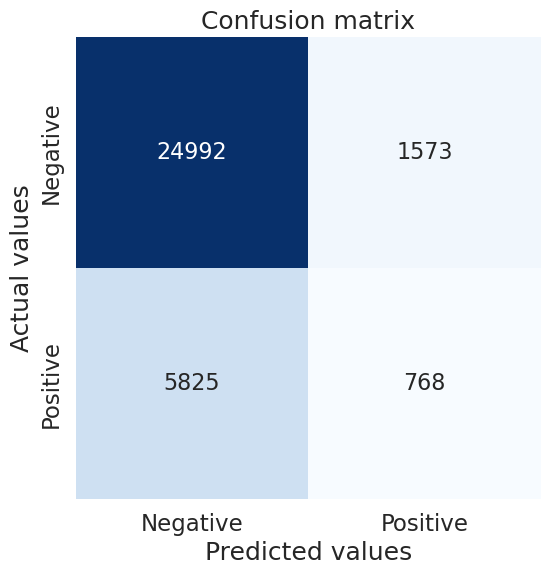

In [88]:
# Plot confusion matrix
plot_confusion_matrix(cnf_matrix, title="Confusion matrix")

In [89]:
# Plot ROC Curve
plot_roc_curve(x_test, y_test, lr)

# Decision tree classifier

In [90]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.tree import export_graphviz
import graphviz

In [91]:
# Create Decision Tree classifer object
dt = DecisionTreeClassifier(class_weight="balanced")

# Train Decision Tree Classifer
dt = dt.fit(x_train,y_train)

#Predict the response for test dataset
y_hat = dt.predict(x_test)

In [92]:
# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_hat))

Accuracy: 0.6430424030399904


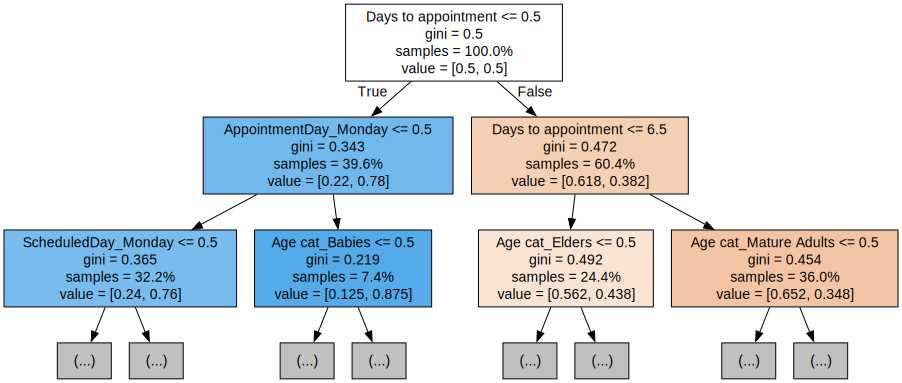

In [93]:
# Visualize tree
dot_data = export_graphviz(dt,
                           feature_names = x_train.columns,
                           filled = True,
                           max_depth=2,
                           impurity=True,
                           proportion = True)
graph = graphviz.Source(dot_data)
display(graph)

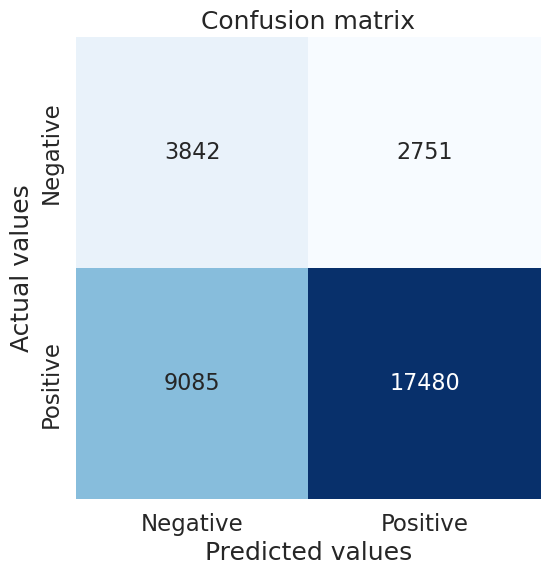

In [94]:
# Confusion Matrix
cnf_matrix = confusion_matrix(y_test, y_hat, labels=[0,1])

# Plot confusion matrix
plot_confusion_matrix(cnf_matrix, title="Confusion matrix")

# Plot ROC Curve
plot_roc_curve(x_test, y_test, dt)

## Optimise Decision tree

In [95]:
from sklearn.model_selection import GridSearchCV

In [96]:
parameters = {'criterion':['gini','entropy','log_loss'], 'max_depth':[3,4,5,6,None]}
dt = DecisionTreeClassifier(class_weight="balanced")
clf = GridSearchCV(dt, parameters, cv=5)

clf.fit(x_train, y_train)

print("Best estimator : ", clf.best_estimator_)
print("Best_score : ", clf.best_score_)
print("Best parameters : ", clf.best_params_)

grid_results = pd.DataFrame(clf.cv_results_)

Best estimator :  DecisionTreeClassifier(class_weight='balanced')
Best_score :  0.6518975250145135
Best parameters :  {'criterion': 'gini', 'max_depth': None}


In [97]:
# Create Decision Tree classifer object
dt = DecisionTreeClassifier(class_weight="balanced", criterion="gini", max_depth=None)

# Train Decision Tree Classifer
dt = dt.fit(x_train,y_train)

#Predict the response for test dataset
y_hat = dt.predict(x_test)

# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_hat))

Accuracy: 0.6427709753302371


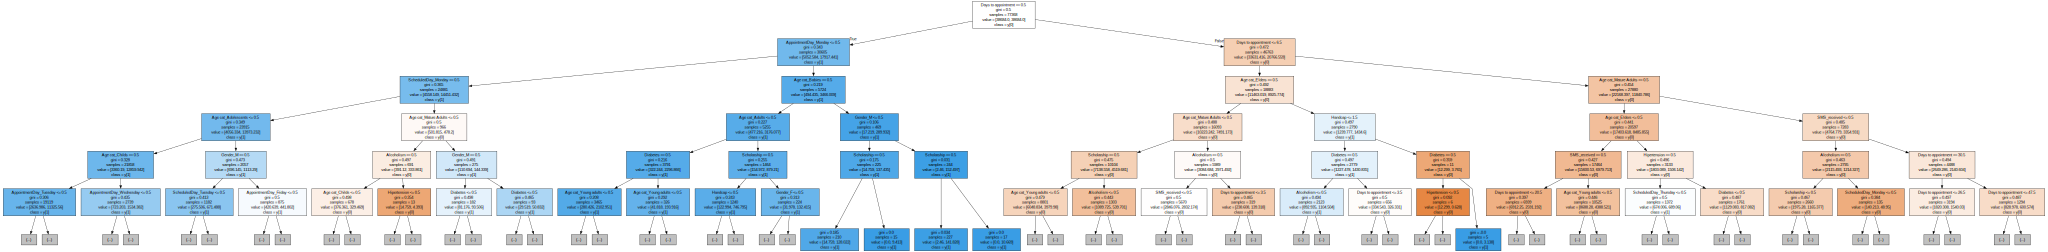

In [98]:
# Visualize tree
dot_data = export_graphviz(dt,
                           feature_names = x_train.columns,
                           filled = True,
                           impurity=True,
                           max_depth=5,
                           proportion = False,
                           class_names = True,
                           leaves_parallel = True)
graph = graphviz.Source(dot_data)
display(graph)

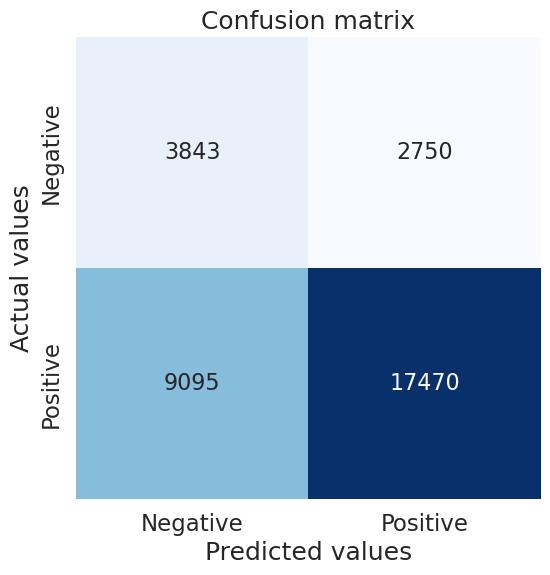

In [99]:
# Confusion Matrix
cnf_matrix = confusion_matrix(y_test, y_hat, labels=[0,1])

# Plot confusion matrix
plot_confusion_matrix(cnf_matrix, title="Confusion matrix")

# Plot ROC Curve
plot_roc_curve(x_test, y_test, dt)

# Conclusions

Unfortunately we cannot conclude from the studied data that some of the variables may predict if a pattien will show or not to an appointment. 

However we saw in the EDA section as well as whithin the Decision tree model, some interesting facts : 
- Contrary to expectations the reception of an SMS to confirm the appointment seems to have a negative impact in the appointment's assistance
- The wating time from the appointment's schedule day and the appointment day seems to have an impact in the assistance. We saw that the farthest the appointment, the more probable is that the pattient will not show to the appointment. This seems logic as some patiens may have lost control over events in far-off dates. We also saw that the reminder SMS did not have an impact in the appointments with far-off appoitnment's dates.